# Linear Classification -j7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import layers
from sixand7 import data_utils, layers

np.set_printoptions(precision=2)

## cifar-10 Data Loading and Preprocessing 

In [2]:
from data_utils import load_CIFAR10
cifar10_dir = '/Users/mahrokh/Desktop/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)
print('x_train: ',x_train.shape)
print('y_train = train label: ',y_train.shape)
print()
print('x_test: ',x_test.shape)
print('y_test = test label: ',y_test.shape)

x_train:  (50000, 32, 32, 3)
y_train = train label:  (50000,)

x_test:  (10000, 32, 32, 3)
y_test = test label:  (10000,)


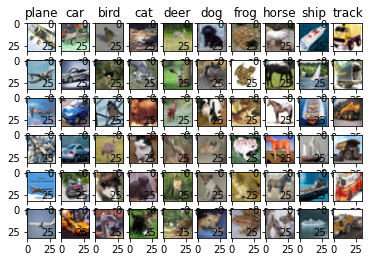

In [3]:
# visualize samples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'track']
num_class = len(classes)
sample_per_class = 6
# print(list(enumerate(classes)))

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i*num_class + y + 1
        plt.subplot(sample_per_class, num_class, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        if i==0:
            plt.title(cls)
plt.show()

In [4]:
# Spilit data into train, val and test sets, development set(to make faster)
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# our validation data
mask = range(num_training, num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

# our training data
mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]

# our development data
mask = np.random.choice(num_training, num_dev)
x_dev = x_train[mask]
y_dev = y_train[mask]

# our test data
mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

print('train data: ',x_train.shape)
print('train labels: ',y_train.shape)
print('Validation data: ',x_val.shape)
print('Validation labels: ',y_val.shape)
print('test data: ',x_test.shape)
print('test labels: ',y_test.shape)


train data:  (49000, 32, 32, 3)
train labels:  (49000,)
Validation data:  (1000, 32, 32, 3)
Validation labels:  (1000,)
test data:  (1000, 32, 32, 3)
test labels:  (1000,)


## Preprocessing, reshape image data into rows

In [5]:
x_train = np.reshape(x_train,(x_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0],-1))
print('training shape 2d:', x_train.shape)
print('Validation data 2d:', x_val.shape)
print('test data 2d:', x_test.shape)
print('dev data 2d:', x_dev.shape)

training shape 2d: (49000, 3072)
Validation data 2d: (1000, 3072)
test data 2d: (1000, 3072)
dev data 2d: (500, 3072)


## Preprocessing, subtracting the mean

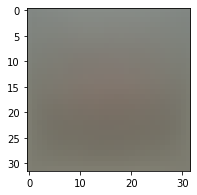

In [6]:
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'));

In [7]:
x_train -= mean_image
x_val -= mean_image
x_test -= mean_image
x_val -= mean_image

## Forward Step:

In [8]:
def affine_forward(w, x, b):
    x2d = np.reshape(x_train, (x_train.shape[0], -1))
    out = np.dot(x2d, w) + b
    cashe = (w, x, b)
    return out, cashe

## SVM:

#### vectorized implementation - svm

In [9]:
def L_i(x, y, w):
    scores = w.dot(x)
    correct_class_score = scores[y]
    c = w.shape[0] # number of classes
    
    loss_i = 0.0
    for j in range(c):
        if j==y:
            continue
        loss_i += max(0, scores[j] - correct_class_score + 1.0)
    return loss_i

In [10]:
def svm_loss_naive(scores, y, W, reg=1e-3):
    """
    Naive implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N, C = scores.shape

    # Compute svm data loss
    loss = 0.0
    for i in range(N):
        s = scores[i]  # scores for the ith data
        correct_class = y[i]  # correct class score

        for j in range(C):
            if j == y[i]:
                continue
            else:
                # loss += max(0, s[j] - s[correct_class] + 1.0)
                margin = s[j] - s[correct_class] + 1.0
                if margin > 0:
                    loss += margin
    loss /= N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

#### Half-vectorized - svm

In [11]:
def L_i(x, y, w):
    scores = w.dot(x)
    margins = np.maximum(0, scores - scores[y] + 1.0)
    margins[y] == 0
    loss_i = np.sum(margins)
    return loss_i

In [12]:
def svm_loss_half_vectorized(scores, y, W, reg=1e-3):
    """
    Half-vectorized implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N, C = scores.shape

    # Compute svm data loss
    loss = 0.0
    for i in range(N):
        s = scores[i]  # scores for the ith data
        correct_class = y[i]  # correct class score

        margins = np.maximum(0.0, s - s[correct_class] + 1.0)
        margins[correct_class] = 0.0
        loss += np.sum(margins)

    loss /= N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

#### Fully-vectorized

In [13]:
def svm_loss(scores, y, W, reg=1e-3):
    """
    Fully-vectorized implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N = scores.shape[0]

    # Compute svm data loss
    correct_class_scores = scores[range(N), y]
    margins = np.maximum(0.0, scores - correct_class_scores[:, None] + 1.0)
    margins[range(N), y] = 0.0
    loss = np.sum(margins) / N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

## create w and b randomly with small numbers

In [14]:
N = x_train.shape[0] # number of rows = training data 49000
D = np.prod(x_train.shape[1:]) # number of column = features 3072
c = 10 # number of classes

w = 0.0001 * np.random.randn(D, c)
b = np.zeros((c,))
print(b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Sanity check for loss function

In [15]:
from layers import affine_forward, svm_loss

In [16]:
def affine_forward(x, W, b):
    """
    A linear mapping from inputs to scores.
    
    Inputs:
        - x: input matrix (N, d_1, ..., d_k)
        - W: weigh matrix (D, C)
        - b: bias vector  (C, )
    
    Outputs:
        - out: output of linear layer (N, C)
    """
    x2d = np.reshape(x, (x.shape[0], -1))  # convert 4D input matrix to 2D    
    out = np.dot(x2d, W) + b               # linear transformation
    cache = (x, W, b)                      # keep for backward step (stay with us)
    return out, cache

In [17]:
scores, _ = affine_forward(x_train, w, b)
loss, _ = svm_loss(scores, y_train, w, reg=0.0)
print('data loss = %.2f' % loss)

data loss = 9.20


In [18]:
print('scores = ', scores[0])
print("correct classs score = %.2f" %scores[0][y_train[0]])

scores =  [ 0.07 -0.28  0.03  0.29  0.41 -0.12 -0.32  0.08  0.28 -0.21]
correct classs score = -0.32


In [19]:
i = 0
margins = scores[i] - scores[i][y_train[i]] + 1.0
margins[y_train[i]] = 0.0
print(margins)
print(np.sum(np.maximum(0.0, margins)))

[1.4  1.05 1.35 1.61 1.73 1.21 0.   1.41 1.61 1.12]
12.481117629667347


## Regularization

In [20]:
L2 = np.sum(w * w)
L1 = np.sum(np.absolute(w)) # i did, it may not be correct
Elastic_net = np.sum(w*w) + np.absolute(w)

## Fully vector SVM

In [21]:
def svm_loss(scores, y, W, reg=1e-3):
    """
    Fully-vectorized implementation of SVM loss function.

    Inputs:
        - scores: scores for all training data (N, C)
        - y: correct labels for the training data
        - reg: regularization strength (lambd)

    Outputs:
       - loss: data loss plus L2 regularization loss
       - grads: graidents of loss wrt scores
    """

    N = scores.shape[0]

    # Compute svm data loss
    correct_class_scores = scores[range(N), y]
    margins = np.maximum(0.0, scores - correct_class_scores[:, None] + 1.0)
    margins[range(N), y] = 0.0
    loss = np.sum(margins) / N

    # Adding L2-regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {} 

    return loss, grads

In [24]:
# to sanity check, after adding regularization, loss increased 
from layers import svm_loss

loss, _ = svm_loss(scores, y_train, w, reg=1e3)
print("loss = %.2f"%loss)

loss = 9.35


## Vectorized VS Unvectorized

In [34]:
import time

# time of naive implementation 
tic = time.time()
loss_naive, _ = svm_loss_naive(scores, y_train, w)
toc = time.time()
naive_time = toc - tic
print('naive loss = %.2f' %naive_time)

# time fully vctorized
tic = time.time()
loss_vectorized, _ = svm_loss(scores, y_train, w)
toc = time.time()
vec_time = toc - tic
print('vectorized loss = %.2f' %vec_time)

# differences and ratio
print('difference = %.2f'%(loss_naive - loss_vectorized))
print('ratio = ',(naive_time/vec_time))

naive loss = 0.33
vectorized loss = 0.01
difference = -0.00
ratio =  35.453978712620376


# Softmax, multi-class Regression loss func

In [39]:
scores = np.array([3.2 , 5.1, -1.7])

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print('scores=', scores)
print('exp_scores=', exp_scores)
print('Probabilities= ', probs)

scores= [ 3.2  5.1 -1.7]
exp_scores= [ 24.53 164.02   0.18]
Probabilities=  [0.13 0.87 0.  ]


In [40]:
# subtract maximum 
scores -= np.max(scores)

# Exponentiation
exp_scores = np.exp(scores)

# Normalization
probs = exp_scores / np.sum(exp_scores)

print('scores=', scores)
print('exp_scores=', exp_scores)
print('Probabilities= ', probs)

scores= [-1.9  0.  -6.8]
exp_scores= [0.15 1.   0.  ]
Probabilities=  [0.13 0.87 0.  ]


## softmax loss function - naïve Implementation 

In [41]:
def softmax_loss_naive(scores, y, W, reg=1e-3):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
        - scores: A numpy array of shape (N, C).
        - y: A numpy array of shape (N,) containing training labels;
        - W: A numpy array of shape (D, C) containing weights.
        - reg: (float) regularization strength

    Outputs:
        - loss as single float
        - gradient with respect to weights W; an array of same shape as W
    """
    N, C = scores.shape

    # compute data loss
    loss = 0.0
    for i in range(N):
        correct_class = y[i]
        score = scores[i]
        score -= np.max(scores)
        exp_score = np.exp(score)
        probs = exp_score / np.sum(exp_score)
        loss += -np.log(probs[correct_class])

    loss /= N

    # compute regularization loss
    loss += 0.5 * reg * np.sum(W * W)

    # Compute gradient off loss function w.r.t. scores
    # We will write this part later
    grads = {}  

    return loss, grads

In [42]:
from layers import softmax_loss_naive

# initialize parameters
w = 0.0001 * np.random.randn(3072, 10)
b = np.zeros((10,))

In [43]:
# compute linear scores
scores, _ = affine_forward(x_train, w, b)

In [45]:
def affine_forward(x, W, b):
    """
    A linear mapping from inputs to scores.
    
    Inputs:
        - x: input matrix (N, d_1, ..., d_k)
        - W: weigh matrix (D, C)
        - b: bias vector  (C, )
    
    Outputs:
        - out: output of linear layer (N, C)
    """
    x2d = np.reshape(x, (x.shape[0], -1))  # convert 4D input matrix to 2D    
    out = np.dot(x2d, W) + b               # linear transformation
    cache = (x, W, b)                      # keep for backward step (stay with us)
    return out, cache

In [47]:
# compute data loss
loss, _ = softmax_loss_naive(scores, y_train, w)
print('loss= %.2f' %loss)

loss= 2.35
